In [ ]:
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 294 kB 2.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Passo 1.1: Carregar o dataset
df = pd.read_csv('heart_2020_cleaned.csv')

# Etapa 1: Pré-Processamento de Dados

Preparação dos dados para garantir que estejam no formato adequado para modelagem.

Objetivos:
* Tratar valores ausentes ou inconsistentes.
* Transformar variáveis categóricas em formatos numéricos (ex.: one-hot encoding).
* Padronizar variáveis numéricas (ex.: normalização).
* Garantir que o dataset seja consistente para as próximas etapas.


In [4]:
# ============================== ETAPA 1: PRÉ-PROCESSAMENTO DOS DADOS ==============================

# Passo 1.2: Remover outliers da coluna BMI usando o método IQR
Q1_bmi, Q3_bmi = df["BMI"].quantile(0.25), df["BMI"].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi
lower_bmi, upper_bmi = Q1_bmi - 1.5 * IQR_bmi, Q3_bmi + 1.5 * IQR_bmi
df_cleaned = df[(df["BMI"] >= lower_bmi) & (df["BMI"] <= upper_bmi)]

# Passo 1.3: Truncar os valores de SleepTime entre 3 e 11 horas
df_cleaned["SleepTime"] = df_cleaned["SleepTime"].clip(lower=3, upper=11)

# Passo 1.4: Balancear a variável alvo HeartDisease usando upsampling
df_majority = df_cleaned[df_cleaned.HeartDisease == "No"]
df_minority = df_cleaned[df_cleaned.HeartDisease == "Yes"]
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Passo 1.5: Transformar colunas binárias ("Yes"/"No") em 1/0
binary_columns = [
    "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking",
    "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"
]
df_balanced[binary_columns] = df_balanced[binary_columns].replace({"Yes": 1, "No": 0})

# Passo 1.6: Transformar a coluna 'Sex' usando one-hot encoding
df_balanced = pd.get_dummies(df_balanced, columns=["Sex"], drop_first=True)

# Identificar colunas categóricas restantes
categorical_columns = df_balanced.select_dtypes(include=['object']).columns

# Aplicar one-hot encoding para todas as colunas categóricas restantes
if len(categorical_columns) > 0:
    df_balanced = pd.get_dummies(df_balanced, columns=categorical_columns, drop_first=True)

/tmp/ipykernel_5803/348262710.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["SleepTime"] = df_cleaned["SleepTime"].clip(lower=3, upper=11)


In [11]:
print(df_balanced.columns)

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'PhysicalActivity', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex_Male', 'HeartDisease_Yes',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good'],
      dtype='object')


# Etapa 2: Divisão e Balanceamento dos Dados

Separação dos dados em conjuntos de treino e teste, além de ajustes para lidar com desbalanceamento de classes.

Objetivos:
* Dividir o dataset em treino (70%) e teste (30%) para avaliação imparcial dos modelos.
* Balancear a variável-alvo para corrigir classes desproporcionais (ex.: upsampling ou downsampling).
* Garantir que o modelo não seja tendencioso para a classe majoritária.


In [5]:
# ============================== ETAPA 2: DIVISÃO DOS DADOS ==============================

# Separar a variável alvo e as preditoras
X = df_balanced.drop(columns=["HeartDisease_Yes"])  # Todas as colunas exceto a variável alvo
y = df_balanced["HeartDisease_Yes"]  # Variável alvo

# Dividir o dataset em conjuntos de treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Combinar X_train e y_train para garantir amostragem consistente
train_combined = pd.concat([X_train, y_train], axis=1)

# Amostrar 30% do conjunto combinado
train_sample = train_combined.sample(frac=0.3, random_state=42)

# Dividir novamente X e y a partir da amostra
X_train_sample = train_sample.drop(columns=y.name)
y_train_sample = train_sample[y.name]

# Verificar tamanhos após a amostragem
print(f"Tamanho de X_train_sample: {X_train_sample.shape}")
print(f"Tamanho de y_train_sample: {y_train_sample.shape}")


Tamanho de X_train_sample: (118948, 37)
Tamanho de y_train_sample: (118948,)


# Etapa 3: Modelos de Classificação

Treinamento de algoritmos de aprendizado de máquina para prever a variável-alvo.

Objetivos:
* Treinar modelos (ex.: Random Forest, Regressão Logística) para prever doenças cardíacas.
* Avaliar o desempenho inicial dos modelos usando validação cruzada.
* Comparar métricas como F1-Score e acurácia entre diferentes classificadores.

In [6]:
# ============================== ETAPA 3: MODELOS DE CLASSIFICAÇÃO ==============================

# Definir os classificadores
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=10, n_jobs=2),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}

# Avaliar os modelos
revised_results = {}
for name, model in classifiers.items():
    # Validação cruzada no conjunto amostral
    scores = cross_val_score(model, X_train_sample, y_train_sample, cv=3, scoring='accuracy', n_jobs=-1)
    avg_score = scores.mean()

    # Treinamento completo no conjunto amostral
    model.fit(X_train_sample, y_train_sample)

    # Predições no conjunto de teste
    y_pred = model.predict(X_test)

    # Armazenar resultados
    revised_results[name] = {
        "Cross-Val Accuracy": avg_score,
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True)
    }

# Exibir resultados
for model_name, results in revised_results.items():
    print(f"\nResultados para {model_name}:")
    print(f"Validação Cruzada - Acurácia: {results['Cross-Val Accuracy']:.2f}")
    print(f"Acurácia no Teste: {results['Test Accuracy']:.2f}")


/home/gabriel/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gabriel/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Resultados para Random Forest:
Validação Cruzada - Acurácia: 0.85
Acurácia no Teste: 0.89

Resultados para Logistic Regression:
Validação Cruzada - Acurácia: 0.77
Acurácia no Teste: 0.76


## 3.1 Random Forest

Por quê usá-lo?:
* Alto desempenho: Random Forest é um algoritmo baseado em múltiplas árvores de decisão que reduz overfitting e é conhecido por sua alta precisão.
* Manuseio de dados mistos: Pode lidar com variáveis contínuas e categóricas, além de detectar relações complexas entre os dados.
* Robustez: Resistente a outliers e dados desbalanceados (com ajustes como pesos nas classes).

Custo:
* Requer mais recursos computacionais devido ao treinamento de múltiplas árvores.
* Mais lento em comparação a modelos simples, mas ainda eficiente para datasets médios como este.

Benefício:
* Excelente desempenho em classificações binárias.
* Capacidade de medir a importância das variáveis, ajudando na interpretação dos resultados.


## 3.2 Regressão Logística

Por que usá-lo?
* Simplicidade: Fácil de implementar e rápido de treinar, ideal para benchmarks iniciais.
* Explicabilidade: Permite interpretar os coeficientes para entender como cada variável contribui para a classificação.
* Eficiência em dados lineares: Funciona bem quando as variáveis preditoras têm uma relação linear com o alvo.

Custo:
* Menor custo computacional (rápido para treinar e testar).
* Menor capacidade de capturar relações não lineares nos dados em comparação com Random Forest.

Benefício:
* É uma excelente escolha para estabelecer uma linha de base e verificar se melhorias com algoritmos mais complexos são significativas.


# 3.3 Conclusão Geral
* O Random Forest é a melhor escolha para este problema devido ao excelente equilíbrio entre custo computacional e desempenho em datasets grandes e complexos.
* A Regressão Logística é ideal para um cenário onde a interpretação do modelo é crucial, mas ainda oferece bom desempenho.
* Modelos como KNN e SVM são mais adequados para problemas menores ou com menos dados, e sua aplicação neste contexto é limitada por custo computacional e escalabilidade.


## 3.4 Resultados (Comparação Custo x Benefício)

Random Forest:
* Benefício: Melhor precisão, ideal para problemas mais complexos.
* Custo: Maior tempo de processamento.

Regressão Logística:
* Benefício: Simplicidade e explicabilidade.
* Custo: Menor precisão em dados não lineares.

O Random Forest é ideal para este dataset por lidar bem com dados grandes, variáveis mistas e relações não lineares. É robusto a outliers e oferece boa generalização, sendo mais adequado para a complexidade do problema do que a Regressão Logística.

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Etapa 4: Avaliação de Desempenho

Análise aprofundada dos resultados dos modelos treinados.

Objetivos:
* Avaliar o desempenho dos modelos com métricas como F1-Score, ROC-AUC e matrizes de confusão.
* Visualizar o desempenho por meio de curvas ROC e matrizes de confusão.
* Identificar erros comuns e onde os modelos podem ser melhorados.

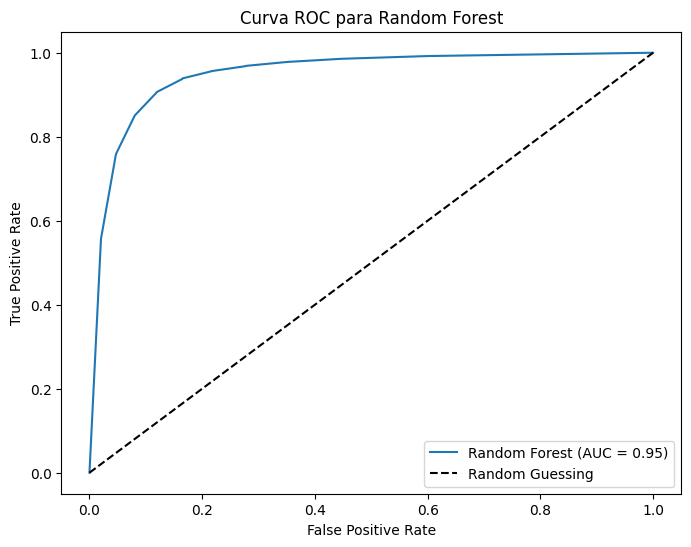

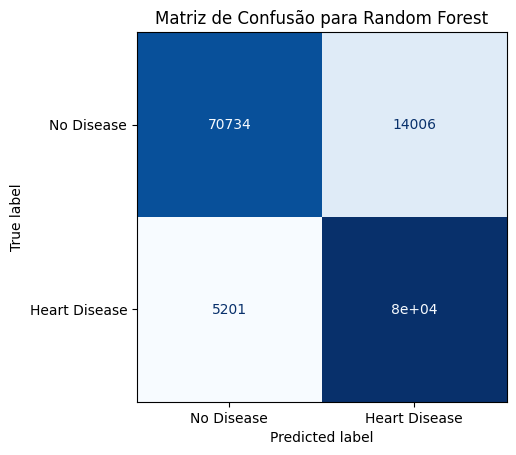

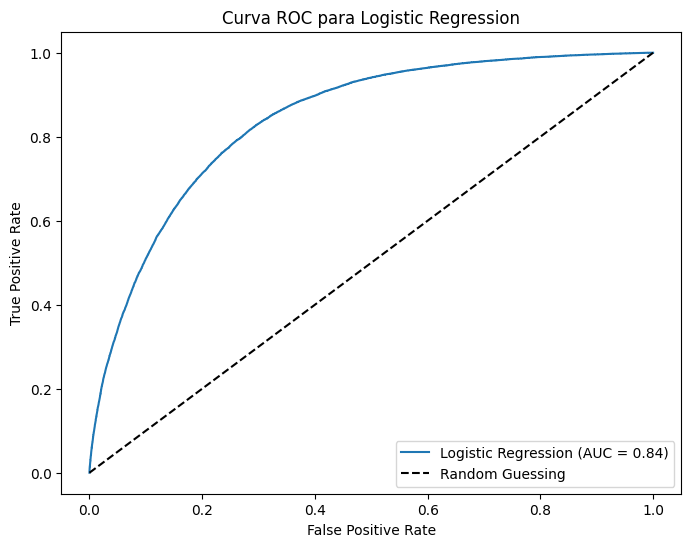

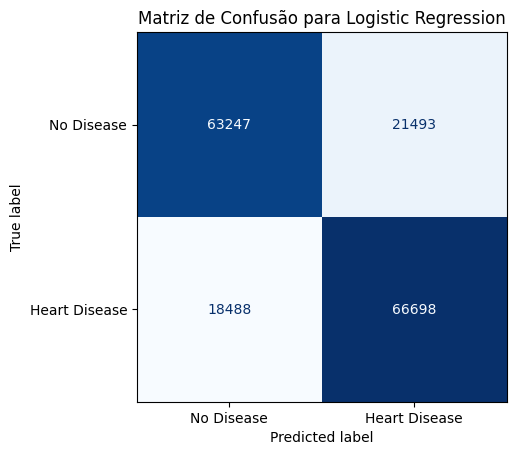

In [ ]:
# ============================== ETAPA 4: AVALIAÇÃO DE DESEMPENHO ==============================
evaluation_results = {}

# Avaliar cada modelo
for name, model in classifiers.items():
    # Passo 4.1: Avaliar usando ROC-AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None

    # Passo 4.2: Plotar curva ROC
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
        plt.title(f"Curva ROC para {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    # Passo 4.3: Avaliar usando F1-Score
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Identificar dinamicamente a chave da classe positiva
    positive_class = next((key for key in report.keys() if key not in ["accuracy", "macro avg", "weighted avg"]), None)

    # Calcular o F1-Score apenas se a classe positiva existir no relatório
    if positive_class and "f1-score" in report[positive_class]:
        f1 = report[positive_class]["f1-score"]
    else:
        f1 = None

    # Passo 4.4: Matriz de Confusão
    confusion = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion, display_labels=["No Disease", "Heart Disease"]).plot(
        cmap='Blues', colorbar=False
    )
    plt.title(f"Matriz de Confusão para {name}")
    plt.show()

    # Registrar métricas no dicionário de resultados
    evaluation_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }


# 4.1 Curva ROC e AUC

* Random Forest:
AUC = 0.95: Isso indica um ótimo desempenho na separação entre classes (No Disease e Heart Disease). Quanto mais próximo de 1, melhor.

* Logistic Regression:
AUC = 0.84: Um bom desempenho, mas inferior ao Random Forest. Isso mostra que a regressão logística não é tão eficaz na separação das classes neste caso.
A curva ROC do Random Forest é mais "inclinada" para o canto superior esquerdo, o que reflete sua maior precisão em comparação à Logistic Regression.

# 4.2 Matrizes de Confusão

Random Forest:
* Falsos Positivos (14,006):
Casos preditos como "Heart Disease", mas que não tinham a condição.
* Falsos Negativos (5,201):
Casos reais de "Heart Disease" que não foram identificados.
* Conclusão:
O modelo apresenta bom equilíbrio, com poucos erros (falsos positivos e falsos negativos), indicando alta confiabilidade.

Logistic Regression:
* Falsos Positivos (21,493):
Mais altos do que no Random Forest, indicando menor precisão.
* Falsos Negativos (18,488):
Significativamente mais altos, o que mostra que o modelo tem dificuldade em identificar corretamente a classe "Heart Disease".
* Conclusão:
A Logistic Regression apresenta desempenho mais limitado, com maior taxa de erros em ambas as categorias.

# 4.3 Comparação Geral

Random Forest:
* Desempenho superior em todas as métricas.
* Baixos falsos positivos e negativos.
* Excelente separação das classes, conforme indicado pela AUC (0.95).

Logistic Regression:
* Desempenho aceitável, mas inferior.
* Altos falsos negativos indicam que muitas condições de doença cardíaca não foram identificadas, o que pode ser crítico dependendo do uso do modelo.

# 4.4 Implicações

Modelo Preferido:
* O Random Forest é o modelo mais adequado, oferecendo um bom equilíbrio entre sensibilidade e especificidade, além de uma AUC alta (0.95).

Contexto do Problema:
* Se os falsos negativos (não detectar doenças cardíacas) forem mais críticos, o Random Forest é claramente a melhor escolha.
* A Logistic Regression pode ser considerada apenas se houver necessidade de maior interpretabilidade.

In [23]:
print(df_balanced.columns)


Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'PhysicalActivity', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex_Male', 'HeartDisease_Yes',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good'],
      dtype='object')


# Etapa 5: Análise Exploratória

Exploração visual e estatística dos dados para entender padrões e relações entre variáveis.

Objetivos:
* Compreender a distribuição de variáveis numéricas e categóricas.
* Identificar correlações entre fatores de risco e a presença de doenças cardíacas.
* Detectar possíveis outliers ou padrões incomuns.

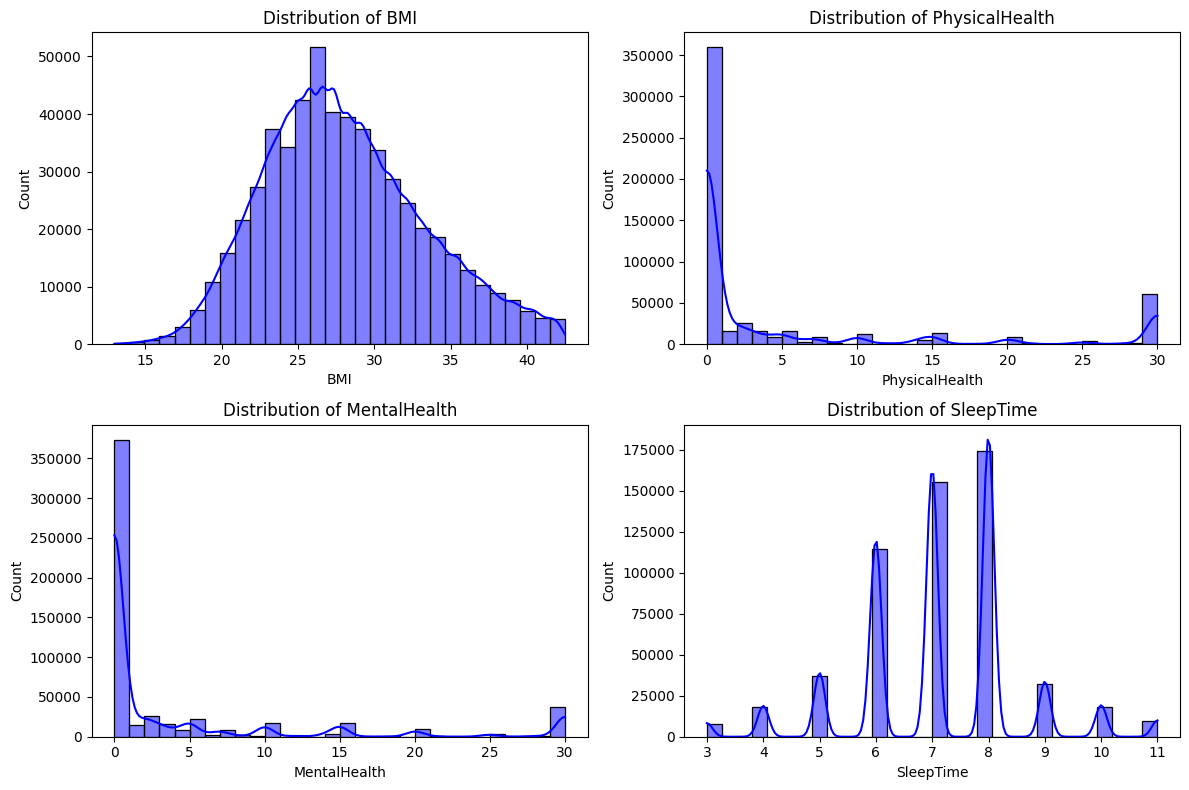

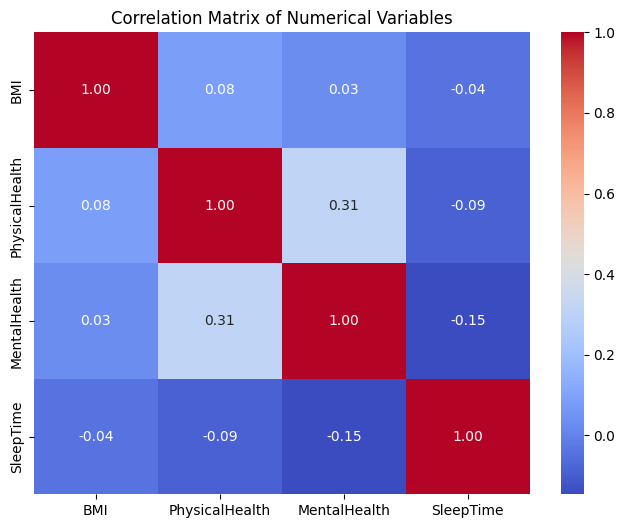

/tmp/ipykernel_5803/838509211.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x="HeartDisease_Yes", palette="coolwarm")


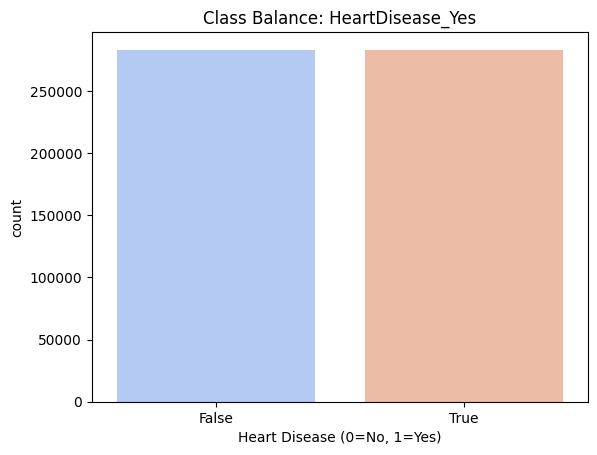

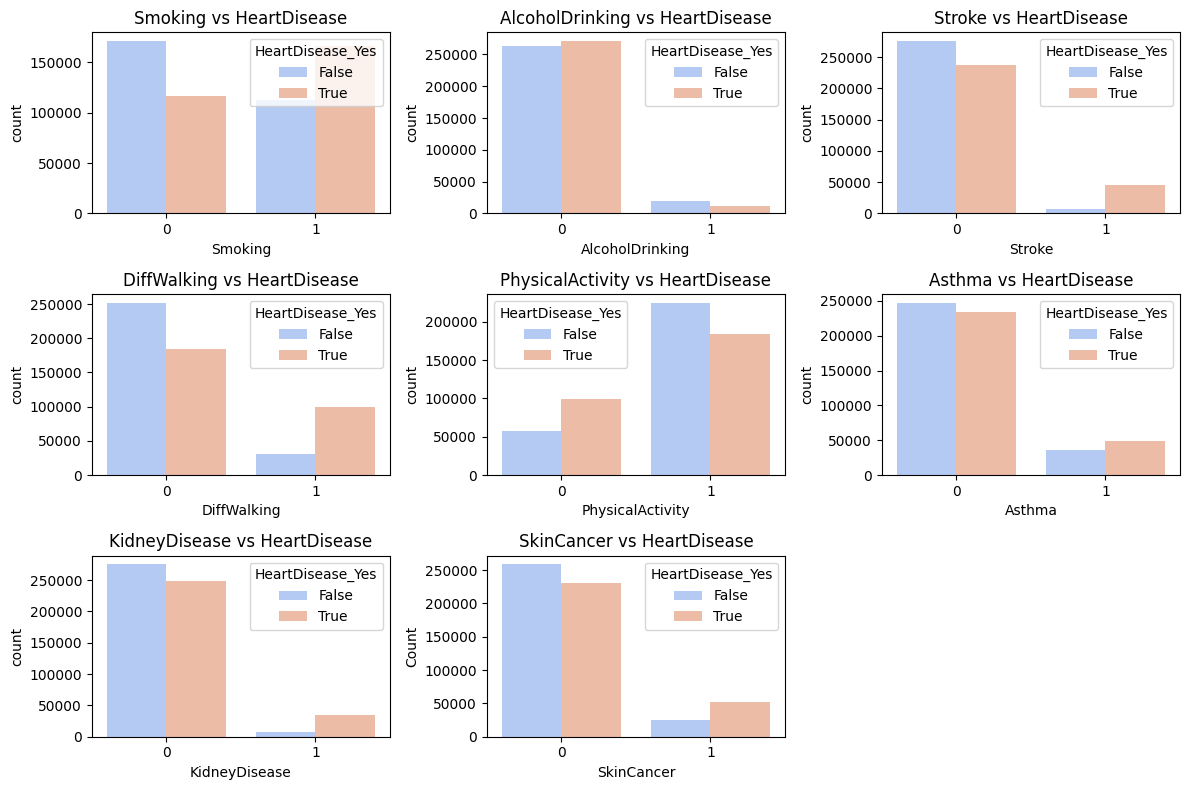

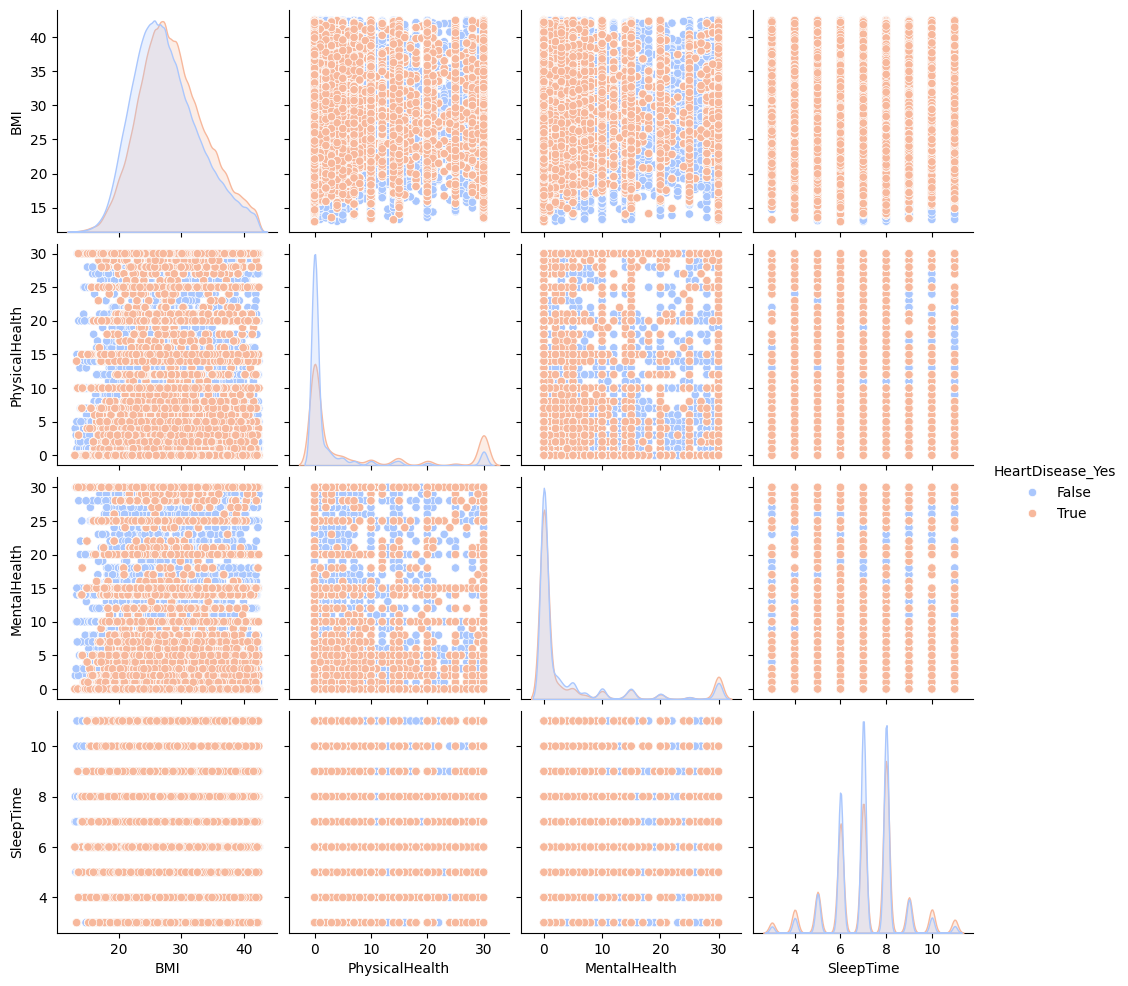

In [12]:
# ============================== ETAPA 5: ANÁLISE EXPLORATÓRIA ==============================
# Passo 5.1: Distribuições de variáveis numéricas
plt.figure(figsize=(12, 8))
numerical_columns = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_balanced[column], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

# Passo 5.2: Matriz de correlação
plt.figure(figsize=(8, 6))
correlation_matrix = df_balanced[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

# Passo 5.3: Balanceamento das classes
sns.countplot(data=df_balanced, x="HeartDisease_Yes", palette="coolwarm")
plt.title("Class Balance: HeartDisease_Yes")
plt.xlabel("Heart Disease (0=No, 1=Yes)")
plt.show()

# Passo 5.4: Relações entre variáveis categóricas e HeartDisease
plt.figure(figsize=(12, 8))
for i, column in enumerate(binary_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df_balanced, x=column, hue="HeartDisease_Yes", palette="coolwarm")
    plt.title(f"{column} vs HeartDisease")
plt.xlabel(column)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Passo 5.5: Matriz de dispersão
sns.pairplot(df_balanced, vars=numerical_columns, hue="HeartDisease_Yes", palette="coolwarm")
plt.show()

# 5.1 Distribuições Individuais

BMI (Índice de Massa Corporal):
* Apresenta uma distribuição aproximadamente normal com um pico em torno de 25-30.
* Valores maiores indicam sobrepeso ou obesidade, fatores de risco conhecidos para doenças cardíacas.

PhysicalHealth e MentalHealth:
* Ambas têm distribuições assimétricas, com a maioria dos valores concentrados em 0, indicando que muitas pessoas relataram boa saúde física e mental na maioria dos dias.
* Os extremos, especialmente valores próximos a 30, sugerem dias significativos de problemas.

SleepTime (Tempo de Sono):
* Mostra uma distribuição multimodal, com picos claros em 6, 7 e 8 horas de sono, o que é consistente com padrões de sono da população geral.

# 5.2 Matriz de Correlação

Este gráfico de calor apresenta a correlação entre as variáveis numéricas:
* Valores próximos de 1 ou -1 indicam alta correlação positiva ou negativa.
* PhysicalHealth e MentalHealth têm a maior correlação positiva (0.31), o que faz sentido, já que saúde física e mental muitas vezes estão relacionadas.
* Outras correlações são fracas, indicando independência relativa entre as variáveis.

# 5.3 Balanceamento de Classes

Este gráfico de barras mostra o equilíbrio entre as classes HeartDisease_Yes (True/False):
* As classes estão aproximadamente balanceadas, o que é importante para evitar viés no treinamento dos modelos de classificação.


# 5.4 Relação Entre Variáveis Binárias e HeartDisease

Esses gráficos de barras agrupadas comparam variáveis binárias (como Smoking, AlcoholDrinking, etc.) com a ocorrência de doenças cardíacas:

Por exemplo:

* Smoking: A proporção de pessoas com doenças cardíacas é maior entre os fumantes (1) do que entre os não fumantes (0).
* PhysicalActivity: Pessoas com atividade física regular (1) têm menor prevalência de doenças cardíacas.
* DiffWalking: Dificuldades para caminhar estão associadas a uma prevalência muito maior de doenças cardíacas.
* Essas relações ajudam a identificar fatores de risco.


# 5.5 Matriz de Dispersão

Este gráfico exibe a relação entre as variáveis numéricas com as classes HeartDisease_Yes diferenciadas por cor (azul para False, laranja para True):

* A densidade de pontos e padrões ajudam a entender como variáveis como BMI, PhysicalHealth, MentalHealth e SleepTime estão relacionadas entre si e com a presença de doenças cardíacas.

Por exemplo:

* O grupo com PhysicalHealth e MentalHealth em valores altos (próximos de 30) parece mais associado a doenças cardíacas.

# Etapa 6: Planejamento de Experimentos

Otimização dos modelos por meio de ajustes de hiperparâmetros.

Objetivos:
* Testar diferentes configurações para os modelos (ex.: Random Forest e Regressão Logística).
* Usar validação cruzada para encontrar os melhores hiperparâmetros.
* Garantir que os modelos estejam otimizados para maximizar métricas como F1-Score.

In [ ]:
# ============================== ETAPA 6: PLANEJAMENTO DE EXPERIMENTOS ==============================


# Garantir que os índices de X_train e y_train sejam consistentes
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)

# Reduzir tamanho do conjunto de treino para ajuste de hiperparâmetros
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index].reset_index(drop=True)

# Passo 6.1: Ajuste de hiperparâmetros para Random Forest com RandomizedSearchCV
param_dist_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}
rf = RandomForestClassifier(random_state=42)

print("Ajustando hiperparâmetros para Random Forest...")
randomized_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
    random_state=42
)
randomized_search_rf.fit(X_train_sample, y_train_sample)
best_params_rf = randomized_search_rf.best_params_
best_score_rf = randomized_search_rf.best_score_

print("Melhores parâmetros para Random Forest:", best_params_rf)
print("Melhor F1-Score (Random Forest):", best_score_rf)

# Passo 6.2: Ajuste de hiperparâmetros para Logistic Regression com RandomizedSearchCV
param_dist_lr = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear"],
    "penalty": ["l2"],
}
lr = LogisticRegression(max_iter=1000, random_state=42)

print("\nAjustando hiperparâmetros para Logistic Regression...")
randomized_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist_lr,
    n_iter=10,
    cv=3,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
    random_state=42
)
randomized_search_lr.fit(X_train_sample, y_train_sample)
best_params_lr = randomized_search_lr.best_params_
best_score_lr = randomized_search_lr.best_score_

print("Melhores parâmetros para Logistic Regression:", best_params_lr)
print("Melhor F1-Score (Logistic Regression):", best_score_lr)

# Passo 6.3: Consolidar resultados dos experimentos
experiment_results = {
    "Random Forest": {"Best Params": best_params_rf, "Best F1-Score": best_score_rf},
    "Logistic Regression": {"Best Params": best_params_lr, "Best F1-Score": best_score_lr},
}

# Exibir resultados consolidados
print("\nResultados consolidados dos experimentos:")
for model_name, results in experiment_results.items():
    print(f"\nModelo: {model_name}")
    print(f"Melhores Parâmetros: {results['Best Params']}")
    print(f"Melhor F1-Score: {results['Best F1-Score']:.4f}")

Ajustando hiperparâmetros para Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros para Random Forest: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Melhor F1-Score (Random Forest): 0.8371523540799378

Ajustando hiperparâmetros para Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros para Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
Melhor F1-Score (Logistic Regression): 0.7683061481744247

Resultados consolidados dos experimentos:

Modelo: Random Forest
Melhores Parâmetros: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Melhor F1-Score: 0.8372

Modelo: Logistic Regression
Melhores Parâmetros: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
Melhor F1-Score: 0.7683
